In [1]:
%matplotlib notebook

import qcodes as qc

from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id

from qcodes import Station
from qcodes import new_experiment

import matplotlib

## Using a monitor

Open a command promt window and type

*activate qcodes_master* 

*python –m qcodes.monitor.monitor*

### Define a new experiment

In [2]:
exp_name = ''
sample_name = ''
# Make sure you create the experiment only once.

# exp = new_experiment(exp_name, sample_name=sample_name)

### Or load an existing one

In [3]:
from qcodes.dataset.experiment_container import load_experiment_by_name

exp = load_experiment_by_name('autotune')
print('Experiment stopped at ID no', exp.last_counter)

Experiment stopped at ID no 251


All data taken will be saved in (ideally) one single database file. Qcodes will save all data in the .db file specified in qc.config.

If the cell below says "./experiments.db", then the default has not been overwritten. If it says something else, then someone has changed the default database location. Please do not change it unless you really want to save data at different locations.

In [4]:
qc.config['core']['db_location']

'C:\\Users\\Administrator\\Documents\\Experiments/experiments.db'

# Option Stationconfigurator

What you will need is a .yaml file, you find a template in the same folder as this notebook

In [5]:
from qdev_wrappers.station_configurator import StationConfigurator

In [6]:
my_config_file = 'system1.yaml'
scfg = StationConfigurator(my_config_file)

In [7]:
# Instantiate some instruments:

mdac = scfg.load_instrument('mdac')
lockin = scfg.load_instrument('sr860')

C:\Users\Administrator\Anaconda3\envs\qcodes_master\lib\site-packages\pyvisa\ctwrapper\functions.py:1647: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x32353532353551040032003E, firmware:1.4) in 3.97s
Connected to: Stanford_Research_Systems SR860 (serial:003121, firmware:V1.47) in 0.09s


### Using the mdac

Make sure you are actually connected to the front panel or the fridge:

In [8]:
mdac.ch56.voltage(0)
mdac.ch56.smc('close')  # front panel
mdac.ch56.microd('close')  # fridge

In [9]:
# Set voltage:
mdac.ch56.voltage(0.1)
# ramp voltage:
mdac.ch56.ramp(0.2)

### Use some home made wrappers

Do a 1d sweep which ramps mdac voltages in between measurement points:

In [10]:
# Load qcodes_measurements into path. We should make the folder installable to avoid these lines.
# It is not needed for where this notebook is sitting originally, just putting in these lines for reference.
# Add/remove depths of the path to add, depending on where you measurement files are located.

import os
import sys

module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from qcodes_measurements.tools.mdac import *

In [11]:
linear1d_ramp?

In [12]:
dataid = linear1d_ramp(mdac.ch60, 0, -1.5, 100, 0.001, lockin.R)

Starting experimental run with id: 1619
Elapsed time in s:  7.985002279281616


Plot the result with all non zero mdac voltages displayed next to the plot:

<IPython.core.display.Javascript object>


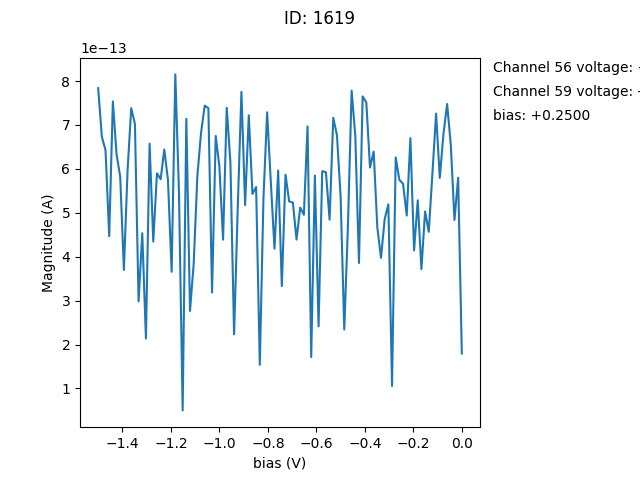

In [13]:
plot_Wtext(dataid, mdac, textcolor='black', fig_folder='.')

Do the same in 2D:

Starting experimental run with id: 1620
Elapsed time in s:  1.776249885559082


<IPython.core.display.Javascript object>


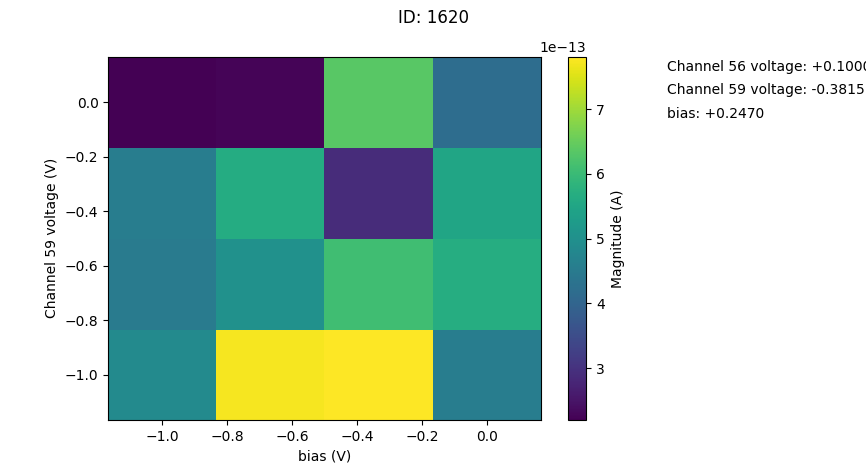

In [14]:
dataid = linear2d_ramp(mdac.ch60, 0, -1, 4, 1.5*lockin.time_constant(),
                       mdac.ch59, 0, -1, 4, 1.5*lockin.time_constant(),
                       lockin.R)
plot_Wtext(dataid, mdac, textcolor='black')

Some convenience functions (which might end up in the driver at some point)

In [15]:
change_filter_all?

In [16]:
all_to_smc?

In [17]:
all_to_microd?

In [18]:
all_to_zero?

In [19]:
ground_all?

### Example of a simple, non wrapped, 1d sweep with v2 dataset
The voltage here is stepped, not ramped as in linear1d_ramp

Starting experimental run with id: 1622


<IPython.core.display.Javascript object>


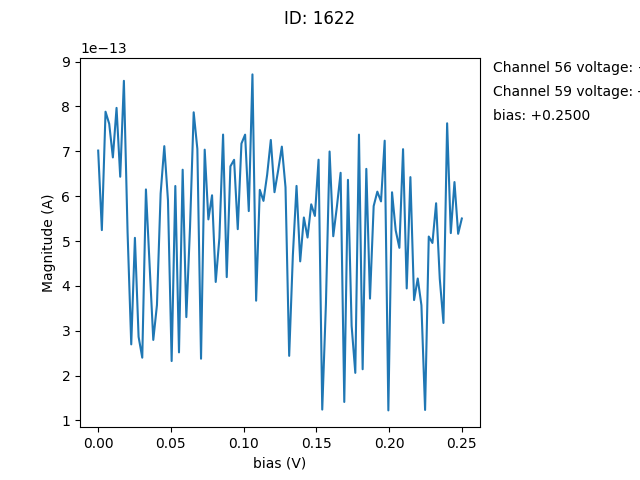

In [21]:
meas = Measurement()
meas.register_parameter(mdac.ch60.voltage)  # register the first independent parameter
meas.register_parameter(lockin.R, setpoints=(mdac.ch60.voltage,))  # now register the dependent oone

meas.write_period = 2

with meas.run() as datasaver:
             
    for set_v in np.linspace(0, 0.25, 100):
        mdac.ch60.voltage.set(set_v)
        get_R = lockin.R.get()
        datasaver.add_result((mdac.ch60.voltage, set_v),
                             (lockin.R, get_R))
    
    dataid = datasaver.run_id  # convenient to have for plotting

plot_Wtext(dataid, mdac, textcolor='black')